<a href="https://colab.research.google.com/github/Polisetty-Cyril/Astronomical-Image-Denoising-and-Enhancement/blob/main/Astronomical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.feature_extraction.image import extract_patches_2d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
hdul = fits.open('/content/hlsp_heritage_hst_acs-wfc_m51_f555w_v1_drz_sci.fits')
image_data = hdul[0].data
hdul.close()
image_data = image_data / np.max(image_data)

In [3]:
def crop_center(img, cropx=512, cropy=512):
  y, x = img.shape
  startx = x // 2 - cropx // 2
  starty = y // 2 - cropy // 2
  return img[starty:starty+cropy, startx:startx+cropx]


image_data = crop_center(image_data)

In [4]:
noise_sigma = 0.1
noisy_image = image_data + np.random.normal(0, noise_sigma, image_data.shape)
patches = extract_patches_2d(noisy_image, (64, 64), max_patches=1000)

In [5]:
def mask_patches(patches, mask_fraction=0.05):
  masked = np.copy(patches)
  masks = np.zeros_like(patches)


  for i in range(len(patches)):
    total = patches[i].size
    n_mask = int(total * mask_fraction)
    coords = np.unravel_index(np.random.choice(total, n_mask, replace=False), patches[i].shape)
    masked[i][coords] = 0
    masks[i][coords] = 1


  return masked, patches, masks


masked_patches, targets, masks = mask_patches(patches)

In [6]:
class PatchDataset64(Dataset):
    def __init__(self, image, patch_size=64, num_patches=1000, mask_ratio=0.25):
        self.patches = []
        self.targets = []
        self.masks = []

        h, w = image.shape
        for _ in range(num_patches):
            y = np.random.randint(0, h - patch_size)
            x = np.random.randint(0, w - patch_size)
            patch = image[y:y + patch_size, x:x + patch_size]

            mask = (np.random.rand(patch_size, patch_size) > mask_ratio).astype(np.float32)
            masked_patch = patch * mask

            self.patches.append(masked_patch)
            self.targets.append(patch)
            self.masks.append(mask)

        self.patches = torch.tensor(np.array(self.patches), dtype=torch.float32).unsqueeze(1)
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.float32).unsqueeze(1)
        self.masks = torch.tensor(np.array(self.masks), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.targets[idx], self.masks[idx]


In [7]:
dataset = PatchDataset64(image_data, num_patches=200, mask_ratio=0.25)
dataloader = DataLoader(dataset, batch_size = 8, shuffle = True)

In [8]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace = True),
          nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace = True)
      )

    self.encoder1 = conv_block(1, 32)
    self.pooling1 = nn.MaxPool2d(2)
    self.encoder2 = conv_block(32, 64)
    self.pooling2 = nn.MaxPool2d(2)

    self.bottleneck = conv_block(64, 128)

    self.up1 = nn.ConvTranspose2d(128, 64, 2, stride = 2)
    self.decoder1 = conv_block(128, 64)
    self.up2 = nn.ConvTranspose2d(64, 32, 2, stride = 2)
    self.decoder2 = conv_block(64, 32)

    self.final = nn.Conv2d(32, 1, 1)

  def forward(self, x):
    e1 = self.encoder1(x)
    e2 = self.encoder2(self.pooling1(e1))
    b = self.bottleneck(self.pooling2(e2))
    d1 = self.decoder1(torch.cat([self.up1(b), e2], dim = 1))
    d2 = self.decoder2(torch.cat([self.up2(d1), e1], dim = 1))
    return self.final(d2)

In [9]:
# Ensure model is defined and instantiated
model = UNet()  # Your deeper/improved U-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y, m in dataloader:
        x, y, m = x.to(device), y.to(device), m.to(device)
        pred = model(x)
        # Only compute loss where mask == 1
        loss = F.mse_loss(pred * m, y * m)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.0222
Epoch 2, Loss: 0.0010
Epoch 3, Loss: 0.0005
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0001
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001


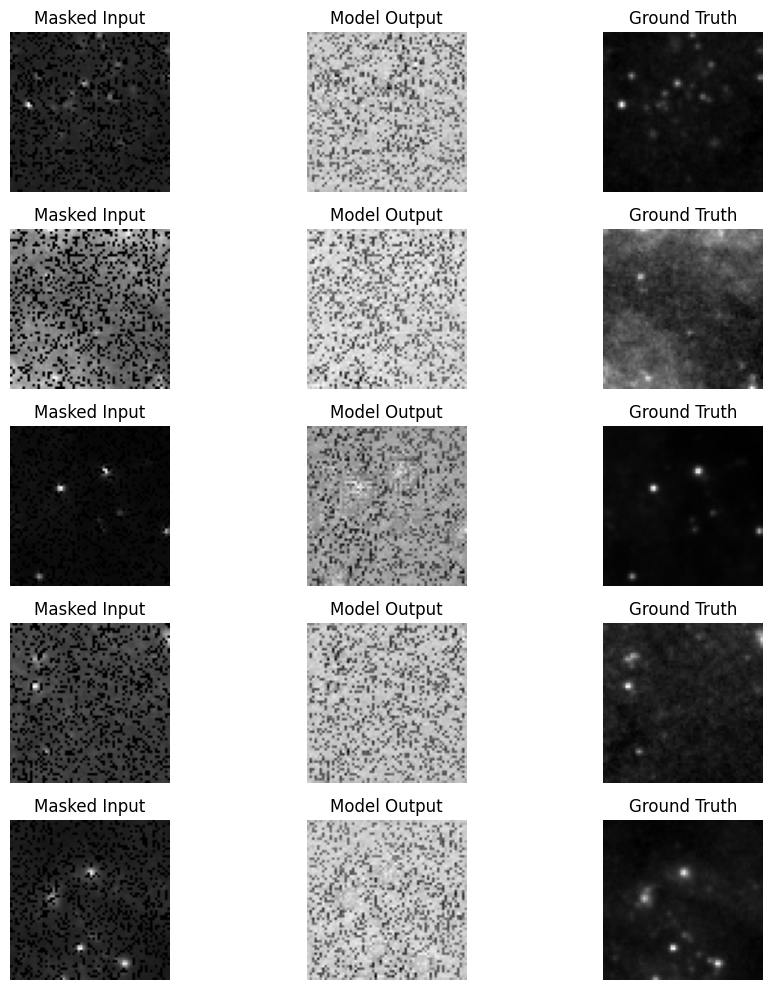

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Switch to evaluation mode
model.eval()

# Get a batch from dataloader
with torch.no_grad():
    for masked, target, mask in dataloader:
        masked, target, mask = masked.to(device), target.to(device), mask.to(device)
        pred = model(masked)
        break  # just one batch

# Move tensors to CPU and squeeze channel for plotting
masked = masked.cpu().squeeze(1).numpy()
target = target.cpu().squeeze(1).numpy()
pred = pred.cpu().squeeze(1).numpy()

# Plot a few examples
n = 5  # Number of examples to show
fig, axes = plt.subplots(n, 3, figsize=(10, 2 * n))
for i in range(n):
    axes[i, 0].imshow(masked[i], cmap='gray')
    axes[i, 0].set_title("Masked Input")
    axes[i, 1].imshow(pred[i], cmap='gray')
    axes[i, 1].set_title("Model Output")
    axes[i, 2].imshow(target[i], cmap='gray')
    axes[i, 2].set_title("Ground Truth")
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()
